In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SEED = 42
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [1]:
import sys
sys.path.append('../scripts')

In [2]:
from training_nn import training_cnn
from evaluation import evaluate_model_rnn, plot_loss, evaluate_model_cnn
from process_data import get_desc

#### One-hot encoding. 

In [4]:
train = pd.read_csv("/kaggle/input/ml-mutational-learning/whole_train.csv")
test = pd.read_csv("/kaggle/input/ml-mutational-learning/whole_test.csv")

In [30]:
def data_split(data, test, target_ab = 'LY555'):
    target_data = data[data['Antibody'] == target_ab]
    train_data = target_data.sample(frac = 0.7, random_state = SEED)
    valid_data = target_data.drop(train_data.index)
    test_data = test[test['Antibody'] == target_ab]
    return train_data, valid_data, test_data
    

In [31]:
train_data, valid_data, test_data = data_split(train, test)

In [46]:
class Onehot_df(Dataset):
    def __init__(self, df):
        self.df = df
        
    @staticmethod
    def _encode_seq(sequence):
        alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        char_to_int = dict((c, i) for i, c in enumerate(alphabet))
        integer_encoded = [char_to_int[char] for char in sequence]
        onehot_encoded = list()
        for value in integer_encoded:
            letter = [0 for _ in range(len(alphabet))]
            letter[value] = 1
            onehot_encoded.append(letter)
        return np.array(onehot_encoded)
     
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        onehot_features = self._encode_seq(self.df.junction_aa.iloc[idx])
        label = self.df.Label.iloc[idx]
        return onehot_features, label

In [47]:
def prepare_dataloader(df, dataset_torch, batch_size = 5, shuffle=True):
    dataset = dataset_torch(df)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = 2)
    return dataloader

In [48]:
trainloader = prepare_dataloader(train_data, Onehot_df, batch_size = 5, shuffle=True)
validloader = prepare_dataloader(valid_data, Onehot_df, batch_size = 5, shuffle=True)
testloader = prepare_dataloader(test_data, Onehot_df, batch_size = 5, shuffle=True)

In [59]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3,
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, 
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, 
                      stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), nn.ReLU()
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction


class RNN(nn.Module):
    def __init__(self, input_size, seq_lentgth, hidden_size, num_layers, num_classes=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=True)
        self.linear1 = nn.Linear(2*seq_lentgth*hidden_size, 100)
        self.linear2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [55]:
model = CNNModel(20, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 16
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 16/16 [05:20<00:00, 20.04s/it]


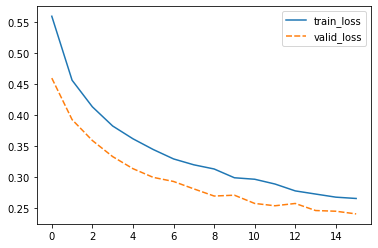

In [56]:
plot_loss(loss_train_hist, loss_valid_hist)

In [57]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.902803,0.852246,0.949934,0.898442,0.961902


__Rnn__

In [66]:
model = RNN(20, 24, 70, 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 15
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 15/15 [11:08<00:00, 44.59s/it]


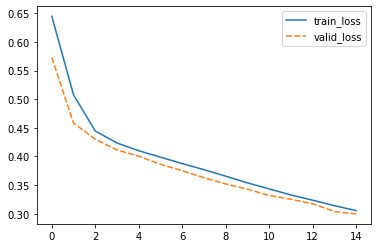

In [67]:
plot_loss(loss_train_hist, loss_valid_hist)

In [68]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.878951,0.853428,0.901373,0.876746,0.942996


###### Insert path to physical features datasets

In [ ]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [69]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [70]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [71]:
train_data, valid_data, test_data = data_split(train, test)

In [75]:
class Phys_features(Dataset):
    def __init__(self, df):
        self.df = df


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        phys_features = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        return phys_features, label

In [76]:
trainloader = prepare_dataloader(train_data, Phys_features, batch_size = 5, shuffle=True)
validloader = prepare_dataloader(valid_data, Phys_features, batch_size = 5, shuffle=True)
testloader = prepare_dataloader(test_data, Phys_features, batch_size = 5, shuffle=True)

In [77]:
model = CNNModel(40, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 16
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 16/16 [05:11<00:00, 19.47s/it]


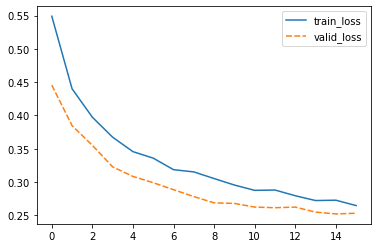

In [78]:
plot_loss(loss_train_hist, loss_valid_hist)

In [79]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.902206,0.847518,0.953457,0.897372,0.959425


In [80]:
model = RNN(40, 24, 70, 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 15
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 15/15 [10:25<00:00, 41.70s/it]


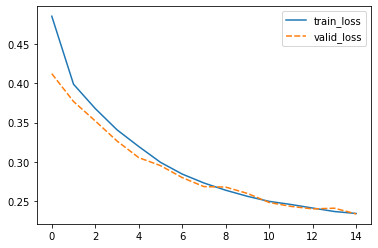

In [81]:
plot_loss(loss_train_hist, loss_valid_hist)

In [82]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.905188,0.868794,0.938697,0.902394,0.957798
